<a href="https://colab.research.google.com/github/strunasik/Tensorflow-unet/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**U-Net** Instance Segmentation using **Tensorflow** and **keras**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necessary packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras import layers

import glob

Working constants initialization

In [3]:
img_size = (128, 128)
num_classes = 3
batch_size = 50

##Collecting data paths

In [4]:
#-------------------LOADING DATA-------------
training_pics = glob.glob('./drive/MyDrive/dataset/training/*.png')

train_images = sorted([p for p in training_pics if 'mask' not in p])
train_masks = sorted([p for p in training_pics if 'mask' in p])

print('TRAINING SET: len(train_images) =', len(train_images), ' len(train_masks) =', len(train_masks))

testing_pics = glob.glob('./drive/MyDrive/dataset/testing/*.png')

test_images = sorted([p for p in testing_pics if 'mask' not in p])
test_masks = sorted([p for p in testing_pics if 'mask' in p])

print('VALIDATION SET: len(test_images) =', len(test_images), ' len(test_masks) =', len(test_masks))


TRAINING SET: len(train_images) = 1700  len(train_masks) = 1700
VALIDATION SET: len(test_images) = 300  len(test_masks) = 300


In [5]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Let's take a look how input image and corresponding segmentation mask look like

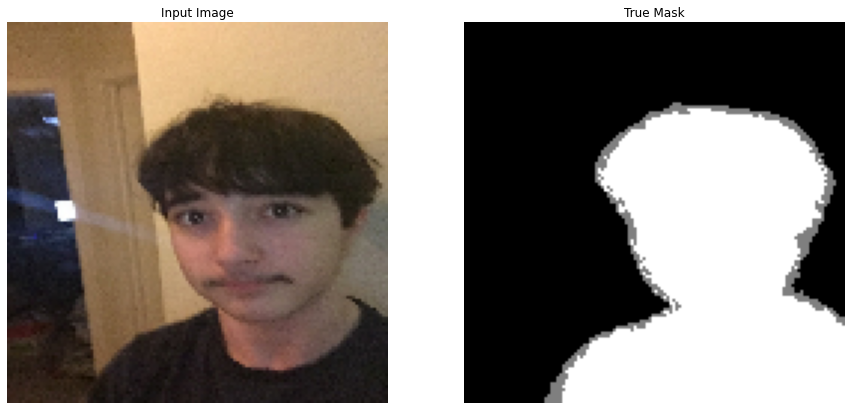

In [6]:
index = np.random.randint(len(train_images))

sample_img = load_img(train_images[index], target_size=img_size)
sample_mask = load_img(train_masks[index], target_size=img_size)
display([sample_img, sample_mask])

##Prepare Sequence class to load & vectorize batches of data

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    """Prepare batches of data for model (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # mask[x,y] є (0, 126, 254). Devide by 126 to make them 0, 1, 2:
            y[j] = y[j] // 126
        return x, y

##Prepare U-Net model

In [8]:
def unet_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    ### [First half of the network: DOWNSAMPLING INPUTS] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: UPSAMPLING INPUTS] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2DTranspose(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model

In [9]:
# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = unet_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

Loading dataset

In [10]:
# Instantiate data Sequences for each split
train_gen = DataGenerator(batch_size, img_size, train_images, train_masks)
val_gen = DataGenerator(batch_size, img_size, test_images, test_masks)

##Compiling and training our net

In [11]:


# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/15
34/34 [==============================] - 56s 1s/step - loss: 2.6713 - val_loss: 3.2100
Epoch 2/15
34/34 [==============================] - 48s 1s/step - loss: 0.5028 - val_loss: 0.8961
Epoch 3/15
34/34 [==============================] - 47s 1s/step - loss: 0.4311 - val_loss: 1.3908
Epoch 4/15
34/34 [==============================] - 46s 1s/step - loss: 0.4409 - val_loss: 0.9791
Epoch 5/15
34/34 [==============================] - 48s 1s/step - loss: 0.3444 - val_loss: 0.8898
Epoch 6/15
34/34 [==============================] - 47s 1s/step - loss: 0.2942 - val_loss: 0.8485
Epoch 7/15
34/34 [==============================] - 48s 1s/step - loss: 0.2845 - val_loss: 0.6685
Epoch 8/15
34/34 [==============================] - 46s 1s/step - loss: 0.2533 - val_loss: 0.9156
Epoch 9/15
34/34 [==============================] - 46s 1s/step - loss: 0.2236 - val_loss: 0.7025
Epoch 10/15
34/34 [==============================] - 45s 1s/step - loss: 0.2011 - val_loss: 0.5797
Epoch 11/15
34/34 [

Loss values on each epoch

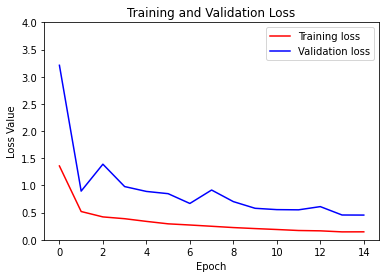

In [12]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 4])
plt.legend()
plt.show()

##Visualize prediction


In [13]:
def create_mask(pred_mask):
    """Quick utility to display a model's prediction."""
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

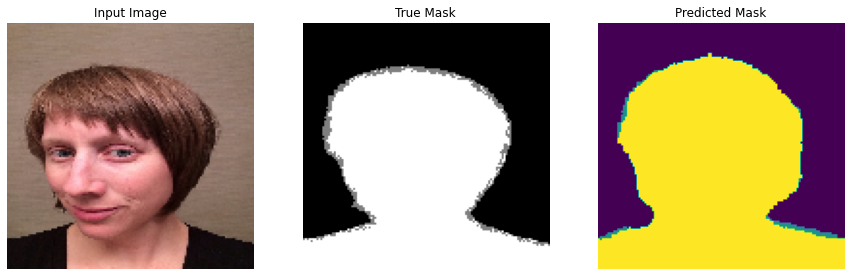

In [14]:
index = np.random.randint(len(train_images))

sample_img = load_img(train_images[index], target_size=img_size)
sample_mask = load_img(train_masks[index], target_size=img_size)
sample_img = np.asarray(sample_img)

prediction = model.predict(sample_img[tf.newaxis, ...])

# Display results for validation image 
display([sample_img, sample_mask, create_mask(prediction)])